# Main Analysis Pipeline
 
 * Prepare Hough transform based only on wire information (= energy, time, radial distance)
 * Build predictions based on Hough, local information, and local information of left/right neighbors 

In [43]:
get_ipython().magic(u'run visualizations.ipynb')
import sys
from hits import CyDetHits, CTHHits, CDCHits
from memory_profiler import memory_usage
sys.path.insert(0, '../modules')

Populating the interactive namespace from numpy and matplotlib


In [44]:
sig_cydet = CyDetHits('../data/151209_signal_tracks.root', 
                      signal_coding=[1], 
                      hit_type_name="tid",
                      branches=["px", "py", "pz", "t","z"])
sig_cth = CTHHits('../data/151209_signal_tracks.root', 
                  signal_coding=[1], 
                  hit_type_name="tid")
sig = CDCHits(sig_cydet, sig_cth)

from cylinder import CyDet
geom = CyDet()
n_events = sig_cth.n_events

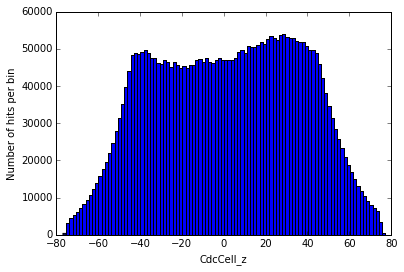

In [45]:
this_feat = "CdcCell_z"
plt.ylabel("Number of hits per bin")
plt.xlabel(this_feat)
plt.hist(sig_cydet.get_signal_hits()[this_feat], bins=100)
plt.show()

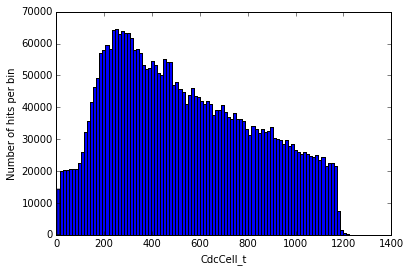

In [46]:
this_feat = "CdcCell_t"
plt.ylabel("Number of hits per bin")
plt.xlabel(this_feat)
plt.hist(sig_cydet.get_signal_hits()[this_feat], bins=100)
plt.show()

## Cuts on the Signal Tracks

In [47]:
# Define cuts to use
n_hits_cut = True
layer_cut = True
timing_cut = True
use_cth_cut = True

### Fiducial Time Window Cuts

In [48]:
if timing_cut:
    # Apply the timing filter
    print "CTH Hits: {}".format(sig.cth.n_hits)
    print "CyDet Hits: {}".format(sig.cydet.n_hits)
    sig.cth.trim_hits(variable=sig.cth.time_name, less_than=1170, greater_than=700)
    sig.cydet.trim_hits(variable=sig.cydet.time_name, less_than=1620, greater_than=700)
    print "CTH Hits: {}".format(sig.cth.n_hits)
    print "CyDet Hits: {}".format(sig.cydet.n_hits)

CTH Hits: 436987
CyDet Hits: 3678861
CTH Hits: 133438
CyDet Hits: 1948467


### Cuts on CTH

In [50]:
# Filter for CTH in time window.  Get the time
trigger_events = []
for evt in range(sig.n_events):
    sig_hits = sig.cth.get_signal_hits(evt)
    if len(sig_hits) != 0:
        trigger_events.append(evt)
trigger_events = np.array(trigger_events)
print "Events that pass CTH Trigger: {}".format(len(trigger_events))

Events that pass CTH Trigger: 15217


### Cuts on CyDet

In [51]:
# Filter for max layer is five
print "Start Events: {}".format(sig.n_events)
max_layer = []
for evt in range(sig.n_events):
    these_layers = sig.cydet.geom.point_layers[sig.cydet.get_sig_wires(evt)]
    if len(sig.cydet.get_sig_wires(evt)) != 0:
        max_layer.append(np.max(these_layers))
    else:
        max_layer.append(-1)
max_layer = np.array(max_layer)
good_max_layer = np.where(max_layer >= 4)[0]
print "End Events: {}".format(sig.n_events)

Start Events: 79587
End Events: 79587


In [52]:
# Filter for number of signal hits
print "Start Events: {}".format(sig.n_events)
n_signal_hits  = np.array([len(sig.cydet.get_signal_hits(evt)) 
                         for evt in range(sig.n_events)])
n_signal_hits = np.array(n_signal_hits)
good_n_hits = np.where(n_signal_hits >= 30)[0]
print "End Events: {}".format(sig.n_events)

Start Events: 79587
End Events: 79587


### Apply the cuts

In [53]:
# Apply quality and CTH cuts
print "Start Events: {}".format(sig.n_events)
passed_events = np.arange(sig.n_events)

if use_cth_cut:
    passed_events = np.intersect1d(passed_events, trigger_events)
    print "Removed due to CTH Trigger {}".format(sig.n_events - len(trigger_events))
if layer_cut:
    passed_events = np.intersect1d(passed_events, good_max_layer)
    print "Removed due to Layer Cut {}".format(sig.n_events - len(good_max_layer))
if n_hits_cut:
    passed_events = np.intersect1d(passed_events, good_n_hits)
    print "Removed due to N Hits Cut {}".format(sig.n_events - len(good_n_hits))

sig.trim_events(passed_events)
print "After All Cuts {}".format(sig.n_events)


Start Events: 79587
Removed due to CTH Trigger 64370
Removed due to Layer Cut 37524
Removed due to N Hits Cut 54997
After All Cuts 9733


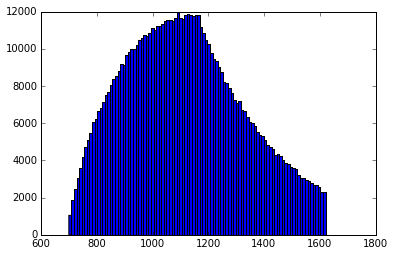

In [54]:
plt.hist(sig.cydet.data[sig.cydet.time_name], bins=100)
show()

## Prepare the data

In [55]:
import pandas
from tracking import HoughSpace
from scipy import sparse
from sklearn.metrics import roc_auc_score, roc_curve

In [56]:
hits_cydet = CyDetHits('../data/151208_SimChen_noise.root', signal_coding=[1], branches="t")
hits_cth = CTHHits('../data/151208_SimChen_noise.root', signal_coding=[1])
hits = CDCHits(hits_cydet, hits_cth)

In [57]:
hits_cydet.all_branches

['CdcCell_t',
 'CdcCell_hittype',
 'CdcCell_nHits',
 'CdcCell_hits_index',
 'CdcCell_event_index',
 'CdcCell_vol_id',
 'CdcCell_edep',
 'CdcCell_tstart',
 'CdcCell_mt']

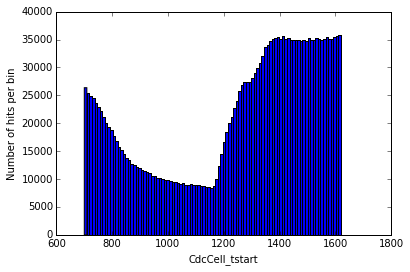

In [58]:
this_feat = "CdcCell_tstart"
plt.ylabel("Number of hits per bin")
plt.xlabel(this_feat)
plt.hist(hits_cydet.get_background_hits()[this_feat], bins=100)
plt.show()

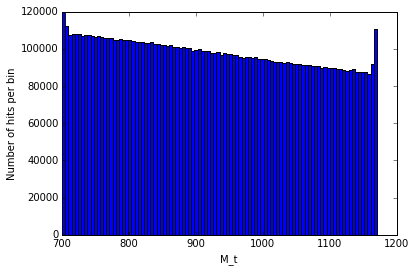

In [59]:
this_feat = "M_t"
plt.ylabel("Number of hits per bin")
plt.xlabel(this_feat)
plt.hist(hits_cth.get_background_hits()[this_feat], bins=100)
plt.show()

In [60]:
print max((hits_cth.get_background_hits()[this_feat]))

1169.99997062


In [61]:
n_events = min(sig.n_events, hits.n_events)
    
hits.trim_events(range(n_events))
sig.trim_events(range(n_events))

In [62]:
if timing_cut:
    # Apply the timing filter
    print "CTH Hits: {}".format(hits.cth.n_hits)
    print "CyDet Hits: {}".format(hits.cydet.n_hits)
    hits.cth.trim_hits(variable=hits.cth.time_name, less_than=1170, greater_than=700)
    hits.cydet.trim_hits(variable=hits.cydet.time_name, less_than=1620, greater_than=700)
    print "CTH Hits: {}".format(hits.cth.n_hits)
    print "CyDet Hits: {}".format(hits.cydet.n_hits)

CTH Hits: 9816474
CyDet Hits: 2181683
CTH Hits: 9816474
CyDet Hits: 2181683


### Set the trigger time

In [63]:
# Set the trigger times
trig_time_evt = []
for evt in range(sig.n_events):
    sig_hits = sig.cth.get_signal_hits(evt)
    if len(sig_hits) != 0:
        this_trig_time = sig_hits[sig.cth.time_name][0]
        trig_time_evt.append(this_trig_time)
        sig.cydet.data[sig.cydet.trig_name][sig.cydet.event_to_hits[evt]] = this_trig_time
        hits.cydet.data[hits.cydet.trig_name][hits.cydet.event_to_hits[evt]] = this_trig_time

(array([ 730.,  700.,  645.,  638.,  611.,  536.,  510.,  513.,  461.,  406.]),
 array([  700.01885959,   747.01603201,   794.01320444,   841.01037686,
          888.00754929,   935.00472171,   982.00189414,  1028.99906657,
         1075.99623899,  1122.99341142,  1169.99058384]),
 <a list of 10 Patch objects>)

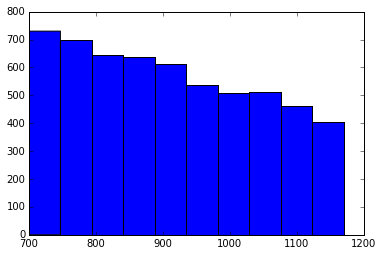

In [64]:
plt.hist(trig_time_evt)

In [65]:
right_neighs = numpy.array([hits.cydet.geom.shift_wire(wire, 1) for wire in range(hits.cydet.geom.n_points)])
left_neighs = numpy.array([hits.cydet.geom.shift_wire(wire, -1) for wire in range(hits.cydet.geom.n_points)])

In [66]:
from scipy.sparse import csr_matrix

In [67]:
# Energy deposits
deposits = numpy.vstack(hits.cydet.get_energy_deposits(i) \
                        + sig.cydet.get_energy_deposits(i) \
                        for i in range(n_events))
deposits *= 100 # to avoid small numbers for GBRT

In [68]:
# get hits on both
# find when signal came sooner
# subtract these from the backgroud mask

In [69]:
# Figure out coincidence
sig_time =  numpy.vstack(sig.cydet.get_hit_time(i)  for i in range(n_events)) # + 700.
hit_time =  numpy.vstack(hits.cydet.get_hit_time(i) for i in range(n_events))
# Flatten at first
sig_time = sig_time.flatten()
hit_time = hit_time.flatten()
# Find signal hits
sig_mask = np.where(sig_time != 0)[0]
# Find background hits
hit_mask = np.where(hit_time != 0)[0]
# Find coincidence
both = np.where( (sig_time != 0) & \
                 (hit_time != 0) )[0]
# Find when coincidence meant signal was sooner
sig_sooner = np.where(sig_time[both] < hit_time[both])[0]
# Take these away from background mask
hit_mask = np.setdiff1d(hit_mask, sig_sooner)

In [70]:
print memory_usage()
del sig_time, hit_time
print memory_usage()

[5381.171875]
[5381.171875]


In [71]:
# Time after triggering that signal waveforms starts
sig_rel_time =  numpy.vstack(sig.cydet.get_relative_time(i)  for i in range(n_events))
hit_rel_time =  numpy.vstack(hits.cydet.get_relative_time(i) for i in range(n_events))
# Flatten at first
sig_rel_time = sig_rel_time.flatten()
hit_rel_time = hit_rel_time.flatten()
# Define the overall relative time
rel_time = hit_rel_time
# Factor in signal (and coincidence)
rel_time[sig_mask] = sig_rel_time[sig_mask]
# Reshape bacl
rel_time = rel_time.reshape((n_events,-1))

In [72]:
print memory_usage()
del sig_rel_time, hit_rel_time
print memory_usage()

[5381.171875]
[5381.171875]


In [73]:
# Get truth data about track momentum
entry_z = np.zeros(n_events)
entry_px = np.zeros(n_events)
entry_py = np.zeros(n_events)
entry_pz = np.zeros(n_events)

for i in range(n_events):
    these_sig = sig.cydet.get_signal_hits(i)
    first_hit = np.argmin(these_sig["CdcCell_t"])
    entry_z[i] = these_sig["CdcCell_z"][first_hit]
    entry_px[i] = these_sig["CdcCell_px"][first_hit]
    entry_py[i] = these_sig["CdcCell_py"][first_hit]
    entry_pz[i] = these_sig["CdcCell_pz"][first_hit]

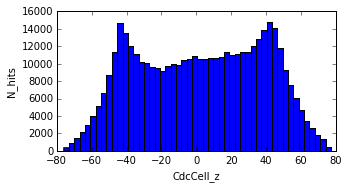

In [74]:
figsize(5,2.5)
all_sig = sig.cydet.get_signal_hits()
plt.hist(all_sig["CdcCell_z"], bins=50)
plt.xlabel("CdcCell_z")
plt.ylabel("N_hits")
plt.show()

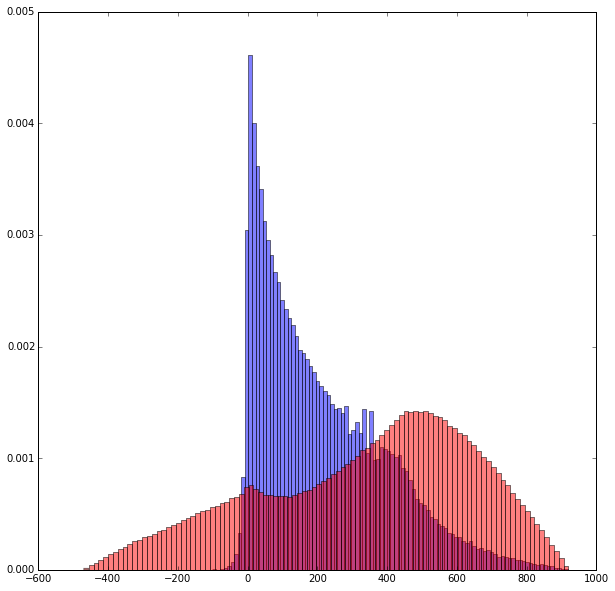

436222
2180195


In [75]:
figsize(10,10)
plt.hist(rel_time.flatten()[sig_mask], bins=100,  color='blue', alpha=0.5, normed=True)
plt.hist(rel_time.flatten()[hit_mask], bins=100,  color='red', alpha=0.5, normed=True)
show()
print len((rel_time.flatten()[sig_mask]))
print len((rel_time.flatten()[hit_mask]))

In [76]:
# Truth Values
sig_labels = numpy.vstack(sig.cydet.get_hit_types(i) for i in range(n_events))
hit_labels = numpy.vstack(hits.cydet.get_hit_types(i) for i in range(n_events)) 
# Flatten at first
sig_labels = sig_labels.flatten()
hit_labels = hit_labels.flatten()
# Define the overall relative time
labels =  hit_labels
# Factor in signal (and coincidence)
labels[sig_mask] = sig_labels[sig_mask]
# Reshape bacl
labels = labels.reshape((n_events,-1))

In [77]:
# Layer ID of hit wires
layer_id = numpy.vstack(geom.point_rhos for i in range(n_events))

In [78]:
labels.shape, deposits.shape

((5750, 4482), (5750, 4482))

In [79]:
def flatten_data(data, keys, samples, n_features):
    return pandas.DataFrame(data=data[samples].reshape(-1, n_feats), columns=keys)

def mask(data, pol=None):
    if pol==None:
        return data[data['labels'] != 0]
    if pol==0:
        return data[(data['labels'] != 0) & (data['Polarity'] == 0)]
    if pol==1:
        return data[(data['labels'] != 0) & (data['Polarity'] != 0)]

def predict_classifier(classifier, data_samp):
    """
    Return predictions where no hit has zero response by definition.  Return both
    flat predictions, and event sorted predicitions
    """
    # Get the predictions
    pred_evt = classifier.predict_proba(data_samp)[:,1]

    # Check which wires have hits, which ones do not
    not_hit = (data_samp['labels'] == 0).values
    has_hit = (data_samp['labels'] != 0).values

    # Define hit-less wires as definitely not being signal
    pred_evt[not_hit] = 0

    # Slim down the result to a copy with only hits
    pred = pred_evt[has_hit]
    # Reshape the result to be the event shape, for the hoguh transform
    pred_evt = pred_evt.reshape(-1, geom.n_points)
    
    return pred, pred_evt

In [80]:
## Look up table to map from events to hits
event_to_hit_look = np.arange(n_events*geom.n_points).reshape(n_events, -1)

In [81]:
from sklearn.cross_validation import train_test_split
rest, sample_3 = train_test_split(range(len(labels)), train_size=0.6, test_size=0.3)
sample_1, sample_2 = train_test_split(rest, train_size=0.5, test_size=0.5)

In [82]:
data_1, data_2, data_3 = pandas.DataFrame(), pandas.DataFrame(), pandas.DataFrame()

for data_samp, samp in zip([data_1, data_2, data_3],\
                           [sample_1, sample_2, sample_3]):
    # Wire features
    data_samp['deposit'] = (deposits * 100)[samp].flatten()
    data_samp['rel_time'] = rel_time[samp].flatten()
    data_samp['layer_id'] = layer_id[samp].flatten()

    # LR-Neighbour Features
    data_samp['r_deposit'] = (deposits * 100)[:, right_neighs][samp].flatten()
    data_samp['r_rel_time'] = rel_time[:, right_neighs][samp].flatten()
    data_samp['l_deposit'] = (deposits * 100)[:, left_neighs][samp].flatten()
    data_samp['l_rel_time'] = rel_time[:, left_neighs][samp].flatten()

    # Truth values
    data_samp['labels'] = labels[samp].flatten()
    data_samp['is_signal'] =  numpy.take([0, 1, 0], labels.astype(int))[samp].flatten()

In [83]:
print memory_usage()
del deposits, rel_time, layer_id, labels
print memory_usage()

[6030.30078125]
[6030.30078125]


In [84]:
print memory_usage()
del sig, hits, sig_cydet, sig_cth, hits_cydet, hits_cth
memory_usage()

[6030.30078125]


[5393.703125]

In [85]:
print list(data_1.columns.astype(str))

['deposit', 'rel_time', 'layer_id', 'r_deposit', 'r_rel_time', 'l_deposit', 'l_rel_time', 'labels', 'is_signal']


In [86]:
# Define Data
train_features = list(data_1.columns[:-2])
n_feats = len(data_1.columns)
feature_labels = list(data_1.columns)

In [87]:
#data_1, data_2, data_3 = [flatten_data(numpy.dstack(features.values()),\
#                                       feature_labels, samp, n_feats)\
#                         for samp in [sample_1, sample_2, sample_3]]

In [88]:
entry_z_1, entry_z_2, entry_z_3 = [entry_z[samp] for samp in [sample_1, sample_2, sample_3]]
entry_px_1, entry_px_2, entry_px_3 = [entry_px[samp] for samp in [sample_1, sample_2, sample_3]]
entry_py_1, entry_py_2, entry_py_3 = [entry_py[samp] for samp in [sample_1, sample_2, sample_3]]
entry_pz_1, entry_pz_2, entry_pz_3 = [entry_pz[samp] for samp in [sample_1, sample_2, sample_3]]

In [89]:
from rep.metaml.factory import ClassifiersFactory
from rep.estimators import SklearnClassifier, TMVAClassifier
from sklearn.ensemble import GradientBoostingClassifier
from rep.report.metrics import RocAuc

In [ ]:
factory = ClassifiersFactory()

# Define GBDT over neighbour-level features
neigh_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                    features=train_features)
# Add the GBDT
factory.add_classifier('Local and Neighbour Features', neigh_gbdt)

In [ ]:
# Train the classifier
factory.fit(mask(data_1), mask(data_1)['is_signal'])
pass

In [ ]:
memory_usage()
del data_1
memory_usage()

In [ ]:
# Print these predictions
pred_2, pred_evt_2 = predict_classifier(neigh_gbdt, data_2)

In [ ]:
# Define which wires we want to correct as hits which were missclassified 
problem_weights_2 = (mask(data_2)['labels'] != 0) * abs(mask(data_2)['is_signal'] - pred_2) ** 2

In [ ]:
print roc_auc_score(mask(data_2)['is_signal'], pred_2)
print roc_auc_score(mask(data_2)['is_signal'], pred_2, sample_weight=problem_weights_2)

In [ ]:
from tracking import HoughSpace

default = [[31.5, 34, 34.5, 2]]
submatrices = []

# Define even and odd layer wires
even_wires = geom.point_pol != 1
odd_wires = geom.point_pol == 1

# TODO test with several radii
for rmin, rmean, rmax, rsgma in default: #[[30, 33, 35], [26, 29, 32]]:
    # Try with default values
    hough = HoughSpace(geom, sig_rho_min=rmin, sig_rho=rmean, sig_rho_max=rmax,\
                       sig_rho_sgma=rsgma, rho_bins=20, arc_bins=81)
    corresp = hough.correspondence
    submatrices.append(corresp)

# Stack all submatricies horizontally
new_correspondence = sparse.hstack(submatrices)

In [ ]:
from tracking import HoughTransformer, HoughShifter
# Fit and transform the second data sample
hough_transformer = HoughTransformer(new_correspondence, \
                                     hough.norm_track_neighs,\
                                     pred_evt_2, alpha_max=2., alpha_rw=2.)

In [ ]:
# Predict for third sample
pred_3, pred_evt_3 = predict_classifier(neigh_gbdt, data_3)

# Get the hough results
hough_result_2, hough_image_2 = hough_transformer.transform(pred_evt_2)
hough_result_3, hough_image_3 = hough_transformer.transform(pred_evt_3)

In [ ]:
# Do the first transform to get the hough space that needs to be aligned
aligner = HoughTransformer(new_correspondence, hough.norm_track_neighs, pred_evt_2, alpha_rw=2., alpha_max=2.)
_ , to_align_2 = aligner.transform(pred_evt_2)
_ , to_align_3 = aligner.transform(pred_evt_3)

In [ ]:
# Shift this hough space to get the even and odd layers agreeing
hough_shifter_2 = HoughShifter(hough, 10, -10)
hough_shifter_3 = HoughShifter(hough, 10, -10)

# Get the images
hough_image_even_3 = to_align_3[:,:hough.track.n_points]
hough_image_odd_3 = to_align_3[:,hough.track.n_points:]
# Fit the shifter
ideal_rotate_3, integral_even_3, integral_odd_3 =\
    hough_shifter_3.fit_shift(hough_image_even_3, hough_image_odd_3)
# Shift the result
shift_pred_evt_3 = hough_shifter_3.shift_result(pred_evt_3)
shift_labels_3 = hough_shifter_3.shift_result(data_3['labels'].reshape(-1, geom.n_points))

# Get the images
hough_image_even_2 = to_align_2[:,:hough.track.n_points]
hough_image_odd_2 = to_align_2[:,hough.track.n_points:]
# Fit the shifter
ideal_rotate_2, integral_even_2, integral_odd_2 =\
    hough_shifter_2.fit_shift(hough_image_even_2, hough_image_odd_2)
# Shift the result
shift_pred_evt_2 = hough_shifter_2.shift_result(pred_evt_2)

In [ ]:
# Hough Transform on the shifted results
shifted_hough_result_3, shifted_hough_image_3 = hough_transformer.transform(shift_pred_evt_3)
shifted_hough_result_2, shifted_hough_image_2 = hough_transformer.transform(shift_pred_evt_2)

# Unshift the results to add them as a feature
unshifted_hough_result_3 = hough_shifter_3.shift_result(shifted_hough_result_3, backward=True)
unshifted_hough_result_2 = hough_shifter_2.shift_result(shifted_hough_result_2, backward=True)

In [ ]:
# Add these as features
data_2['Hough'] = hough_result_2.flatten()
data_2['Shift_Hough'] = unshifted_hough_result_2.flatten()

data_3['Hough'] = hough_result_3.flatten()
data_3['Shift_Hough'] = unshifted_hough_result_3.flatten()

In [ ]:
# Add this to the feature list
train_features_full = train_features + ['Hough']
train_features_shift = train_features + ['Shift_Hough']

# Define the new classifier
hough_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                               features=train_features_full) 

s_hough_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                               features=train_features_shift) 

# Define GBDT over only energy deposit to compare
dep_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=200), 
                               features=['deposit'])

# Ensure neigh-level GBDT has enough trees to compare properly
neigh_gbdt.set_params(n_estimators=200)

# Add the classifiers
factory.add_classifier('Shift Hough, Local and Neighbour Features', s_hough_gbdt)
factory.add_classifier('Hough, Local and Neighbour Features', hough_gbdt)
factory.add_classifier('Energy Deposition', dep_gbdt)

In [ ]:
# Train the classifier
factory.fit(mask(data_2), mask(data_2)['is_signal'])
pass

In [ ]:
# Test it on the last set of data
pred_final_diag_3 = factory.test_on(mask(data_3), mask(data_3)['is_signal'])
pred_final_3, pred_final_evt_3 = predict_classifier(hough_gbdt, data_3)
pred_final_shift_3, pred_final_shift_evt_3 = predict_classifier(s_hough_gbdt, data_3)
pred_3, pred_evt_3 = predict_classifier(neigh_gbdt, data_3)

In [ ]:
# TODO clean this up
from collections import OrderedDict

figsize(6.4,6.4) 
feat_label_dict = OrderedDict([
            ('l_rel_time' , "Left Timing"),  
            ('r_rel_time' , "Right Timing"),
            ("layer_id" , "R Distance"), 
            ('r_deposit' , 'Right Energy'), 
            ('l_deposit' , 'Left Energy'), 
            ('rel_time' , "Timing"),
            ('deposit' , 'Energy'), 
            ('Hough' , r"Hough, $W_j''$"),
            ('Shift_Hough' , r"Shift Hough, $W_j'''$"),
        ])

def plot_feature_importance(rep_classifier, feat_label_dict):
    feat_import = rep_classifier.get_feature_importances()
    feat_import = feat_import.sort("effect", ascending=False)
    ax = plt.subplot(111)
    ax.bar( np.arange(len(feat_import.values)), feat_import.values,zorder=10)
    ax.set_xticks(np.arange(len(feat_import.values))+0.5)
    ax.minorticks_on()
    ax.set_ylabel("Normalized Relative Usage")
    ax.set_title("Feature Importance")
    ax.autoscale()
    ax.grid(b=True, which='major', axis='y' ,color='grey', linestyle='--')
    ax.grid(b=True, which='minor', axis='y' , color='grey', linestyle=':')
    ordered_labels = OrderedDict((key, feat_label_dict[key]) for key in feat_import.index.values)
    ax.set_xticklabels(ordered_labels.values(),  rotation='vertical')
    ax.set_yticklabels(["{:.0f}%".format(tick*100) for tick in ax.get_yticks()])
    return ax

def plot_feature_correlations(rep_factory, feat_label_dict):
    corr = pred_final_diag_3.features_correlation_matrix(features=train_features+["Hough"],
                                tick_labels=[feat_label_dict[key] for key in train_features_full])
    corr.fontsize = 15
    corr.cmap = "RdBu"
    return corr.plot()

In [ ]:
hough_level = factory["Hough, Local and Neighbour Features"]
plot_feature_importance(hough_level, feat_label_dict)
show()
plot_feature_correlations(factory, feat_label_dict)
show()

feat_label_dict['Hough'] = r"Shifted Hough, $W_j''$"
s_hough_level = factory["Shift Hough, Local and Neighbour Features"]
plot_feature_importance(s_hough_level, feat_label_dict)
show()
plot_feature_correlations(factory, feat_label_dict)
show()


In [ ]:
plot_feature( (data_3['Hough'].values+0.1), data_3['labels'].values, 
             xlabel="Hough Output", ylabel="Normalised Hit Count", xlog=True,
            title="Reweighted Inverse Hough Output Distribution", nbins=20)

In [ ]:
plot_feature( (data_3['Shift_Hough'].values+0.1), data_3['labels'].values, 
             xlabel="Shifted Hough Output", ylabel="Normalised Hit Count", xlog=True,
            title="Reweighted Inverse Hough Output Distribution", nbins=20)

In [ ]:
print roc_auc_score(mask(data_3)['is_signal'], pred_final_3)
print roc_auc_score(mask(data_3)['is_signal'], pred_final_shift_3)

In [ ]:
figsize(11,6) 
plot_rocs(mask(data_3)["is_signal"], pred_final_diag_3.prediction, zoom=False)
#plt.savefig("/home/elg112/COMET/Presentations_Papers/group_meetings/images/tmva_roc.png", bbox_inches="tight")
show()
plot_rocs(mask(data_3)["is_signal"], pred_final_diag_3.prediction, zoom=True)
#plt.savefig("/home/elg112/COMET/Presentations_Papers/group_meetings/images/tmva_roc_zoom.png", bbox_inches="tight")
show()

In [ ]:
figsize(15,10)
plot_set_font(size=20)
plot_feature( pred_3, mask(data_3)['labels'].values, 
             xlabel="Track Level GBDT Output", ylabel="Normalised Hit Count", 
            title="Track Level GBDT Output Distribution", nbins=20)
show()
plot_feature( pred_final_3, mask(data_3)['labels'].values, 
             xlabel="Track Level GBDT Output", ylabel="Normalised Hit Count",
            title="Track Level GBDT Output Distribution", nbins=20)
show()
plot_feature( pred_final_shift_3, mask(data_3)['labels'].values, 
             xlabel="Track Level GBDT Output", ylabel="Normalised Hit Count",
            title="Track Level GBDT Output Distribution", nbins=20)
show()

In [ ]:
problem_weights_3 = (mask(data_3)['labels'] != 0) * abs(mask(data_3)['is_signal'] - pred_3) ** 2
print roc_auc_score(mask(data_3)['is_signal'], pred_3)
print roc_auc_score(mask(data_3)['is_signal'], pred_3, sample_weight=problem_weights_3)

In [ ]:
problem_weights_3 = (mask(data_3)['labels'] != 0) * abs(mask(data_3)['is_signal'] - pred_final_shift_3) ** 2
print roc_auc_score(mask(data_3)['is_signal'], pred_final_shift_3)
print roc_auc_score(mask(data_3)['is_signal'], pred_final_shift_3, sample_weight=problem_weights_3)

In [ ]:
from sklearn import linear_model
#print linear_model.LinearRegression__doc__
#print linear_model.RANSACRegressor.__doc__

In [ ]:
# Get the actual circle parameters for the fit from the linearized parameters
def get_circle(x_coeff, y_coeff, intercept):
    return x_coeff/2, y_coeff/2, np.sqrt(4*intercept + x_coeff**2 + y_coeff**2)/2

In [ ]:
# Check that the fit returns a circle that passes through the production target
def inside_target(model, X, y):
    a, b, r = get_circle(model.coef_[0][0], model.coef_[0][1], model.intercept_)
    return abs(np.sqrt(a**2 + b**2) - r) < 10

In [ ]:
# Geometric considerations for the fit
wire_x, wire_y = geom.get_points_xs_and_ys()
# Linearize the input problem
wire_xy = np.vstack([wire_x, wire_y]).T
wire_z  = np.square(wire_x) + np.square(wire_y)

In [ ]:
def ransac_fit(labels, preds, min_hits=13, plot=False, no_show=False):
    # Initialze parameters
    x1, y1, r1 = -1.*np.zeros(2), -1.*np.zeros(2), -1.*np.zeros(2)
    x2, y2, r2 = -1.*np.zeros(2), -1.*np.zeros(2), -1.*np.zeros(2)
    this_score = -1.*np.ones(wire_z.shape[0])
    
    # Get wires to fit
    even_sig = np.logical_and(even_wires, preds)
    odd_sig = np.logical_and(odd_wires, preds)
    
    # Plot the input to the fit
    if plot:
        plot_output(labels, geom, size=40*preds)
        plot_add_outlines(labels, geom)

    # Skip if either layer does not have enough hit points
    # if (sum(even_sig) < min_hits) or (sum(odd_sig) < min_hits):
    #     print "Skipped"
    #    if plot:
    #        show()
    #    return

    for pol, signal in enumerate([even_sig, odd_sig]):

        # Get the points to fit
        fit_x, fit_y = wire_x[signal], wire_y[signal]
        fit_xy = np.vstack([fit_x,fit_y]).T
        # Linearize the equation
        fit_z = np.square(fit_x) + np.square(fit_y)

        # Fit line using all data
        model = linear_model.LinearRegression()
        try:
            model.fit(fit_xy, fit_z)
        except ValueError:
            print "Skipped Normal"
            if plot:
                show()
            return None
        
        # Robustly fit linear model with RANSAC algorithm
        model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression(),
                                                   is_model_valid=inside_target,
                                                   max_trials=1000)
        try:
            model_ransac.fit(fit_xy, fit_z)
        except ValueError:
            print "Skipped RANSAC"
            if plot:
                show()
            return None
        
        # Give the unmasked values the inlier_mask_ values or logicial not
        inlier_mask = np.zeros(geom.n_points, dtype=bool)
        outlier_mask = np.zeros(geom.n_points, dtype=bool)
        inlier_mask[signal] = model_ransac.inlier_mask_
        outlier_mask[signal] = np.logical_not(model_ransac.inlier_mask_)
        
        # Plot the output
        labels = np.zeros(geom.n_points)
        labels[inlier_mask] = 1
        labels[outlier_mask] = 2

        # Get the regular fit
        x1[pol], y1[pol], r1[pol] = get_circle(model.coef_[0], model.coef_[1] , model.intercept_)

        # Get the RANSAC fit
        x2[pol], y2[pol], r2[pol] = get_circle(model_ransac.estimator_.coef_[0][0], 
                         model_ransac.estimator_.coef_[0][1] , model_ransac.estimator_.intercept_)

        # Make sure we're plotting all points
        assert sum(labels == 1) + sum(labels == 2) == sum(signal),\
            "{} {}".format(sum(labels == 1) + sum(labels == 2), sum(signal))    
       
        #assert inlier_mask.count() + outlier_mask.count() == signal.count(),\
         #   "{} {}".format(inlier_mask.count() + outlier_mask.count(), signal.count())    
        if plot:
            plot_add_circle(x1[pol], y1[pol], r1[pol])
            print "Fit:" + str(r1[pol])
            plot_add_circle(x2[pol], y2[pol], r2[pol], color="red")
            print "RANSAC Fit:" + str(r2[pol]) + "\n"

        # Score the wires by distance from RANSAC
        this_score = model_ransac.estimator_.predict(wire_xy)[:,0]
        this_score -= wire_z
        this_score = np.absolute(this_score)
    if not no_show:
        show()
    return x1, y1, r1, x2, y2, r2, this_score

In [ ]:
# Define threshold GBDT output to fit to
fpr, tpr, values =  roc_curve(mask(data_3)['is_signal'], pred_final_3)
threshold = np.where(tpr > 0.99)[0][0]
print "TPR: {}".format(tpr[threshold]),      "FPR: {}".format(fpr[threshold]),      "VALUE: {}".format(values[threshold])

# Define the wires to be fit and their locations
cut_pred_final_3 = pred_final_evt_3 > values[threshold]
fit_evts = cut_pred_final_3.shape[0]

In [ ]:
# Score the wires by distance from RANSAC
score = np.zeros(data_3['labels'].shape[0]) 
even_circle = np.zeros((data_3['labels'].reshape(-1,geom.n_points).shape[0],3)) 
odd_circle = np.zeros((data_3['labels'].reshape(-1,geom.n_points).shape[0],3)) 

for evt in range(len(sample_3)):
#for evt in bad_ransac_events:
    if evt%100 == 0:
        print str(evt) + " ", 
    evt_hits = event_to_hit_look[evt]
    to_fit = data_3["labels"].values[evt_hits]
    output = ransac_fit(to_fit, cut_pred_final_3[evt,:])
    if output is not None:
        score[evt_hits] =  output[-1]
        # print  np.array(output[:-1])
        params =  np.array(output[3:-1]).flatten()
        even_circle[evt] = np.array(output[3:-1]).flatten()[::2]
        odd_circle[evt] = np.array(output[3:-1]).flatten()[1::2]

data_3['score'] = score

In [ ]:
print even_circle[10]
print odd_circle[10]
print entry_z_3[10]

In [ ]:
good_ransac_events = np.where(data_3['score'][1::4482] != 0)[0]
bad_ransac_events = np.where(data_3['score'][1::4482] == 0)[0]
n_total_ransac_events = data_3.shape[0]/4482

print n_total_ransac_events 
print len(good_ransac_events)
print len(bad_ransac_events)
print len(good_ransac_events)/float(n_total_ransac_events)
print bad_ransac_events

In [ ]:
plot_feature((mask(data_3)[data_3['score'] != -1]['score'].values +0.001), 
             mask(data_3)[data_3['score'] != -1]['labels'].values, xlog=True,
             xlabel="RANSAC Score Output", ylabel="Normalised Hit Count",
            title="RANSAC Score Output Distribution", nbins=20)
show()

In [ ]:
from scipy.spatial.distance import cdist
from numpy import unravel_index

n_sample_points = 1001

unit_x = np.cos(np.linspace(-np.pi, np.pi, n_sample_points))
unit_y = np.sin(np.linspace(-np.pi, np.pi, n_sample_points))

def crossing_points(circle_a, circle_b, circle_r, fiducial_radius):
    # Define the circle's points
    circle_x = circle_r * unit_x + circle_a
    circle_y = circle_r * unit_y + circle_b    
    
    # Check where these points are at the fiducial radius
    dist_to_fiducal = np.sqrt(np.square(circle_x) + np.square(circle_y)) - fiducial_radius
    max_dist_index = np.argmax(dist_to_fiducal)
    circle_x = np.roll(circle_x, -max_dist_index)
    circle_y = np.roll(circle_y, -max_dist_index)
    dist_to_fiducal = np.roll(dist_to_fiducal, -max_dist_index)
    
    inside_boundary = np.sign(dist_to_fiducal)
    at_boundary = ((np.roll(inside_boundary, -1) - inside_boundary) != 0).astype(int).nonzero()[0]

    try:
        assert len(at_boundary) == 2,\
           "Caution: {} crossing points were found!!"
        d_theta = np.abs(at_boundary[0] - at_boundary[1])/float(n_sample_points) * 2 * np.pi
        if d_theta > np.pi:
            d_theta = 2 * np.pi - d_theta
        # Return the x, y locations of all crossing points
        return circle_x[at_boundary], circle_y[at_boundary], d_theta
    
    except AssertionError:
        return None    

In [ ]:
# TODO Check X, Y at target Z

fiducial_radius = geom.r_by_layer[0] - (geom.r_by_layer[1] - geom.r_by_layer[0])/2.


diff_offset = np.zeros(n_total_ransac_events)
min_offset = np.zeros(n_total_ransac_events)
bad_dist_evts = np.zeros(0)
avg_radius = np.zeros(n_total_ransac_events)
avg_d_theta = np.zeros(n_total_ransac_events)

for nth_circ, circles in enumerate(zip(even_circle, odd_circle)): 

    
    e_circ = circles[0]
    o_circ = circles[1]
    
    # Sign is positive when even circle leads in phi around origin in clockwise direction
#    distance_sign = np.sign(np.arctan(o_circ[1]/o_circ[0]) - np.arctan(e_circ[1]/e_circ[0]))
    
    
    try: 
        e_crs_x, e_crs_y, e_d_theta = crossing_points(e_circ[0], e_circ[1], e_circ[2], fiducial_radius)
        o_crs_x, o_crs_y, o_d_theta = crossing_points(o_circ[0], o_circ[1], o_circ[2], fiducial_radius) 
    except TypeError:
        print "Crossing Error: ",
        print nth_circ
        bad_dist_evts = np.unique(np.append(bad_dist_evts, nth_circ))
        continue
    
    try:
        distances = cdist(zip(e_crs_x, e_crs_y), zip(o_crs_x, o_crs_y))
    except ValueError: 
        print "PDist Error: ",
        print nth_circ,
        bad_dist_evts = np.unique(np.append(bad_dist_evts, nth_circ))
        print zip(e_crs_x, e_crs_y),
        print zip(o_crs_x, o_crs_y)
        continue
    
    if abs(e_d_theta - o_d_theta) > 0.1 * (e_d_theta + o_d_theta)/2.:
        print "Large d_theta disagreement", 
        print nth_circ,
        print e_d_theta, o_d_theta, 
        print e_circ[2], o_circ[2]
        
    min_dist_idx = unravel_index(distances.argmin(), distances.shape)
    if not min_dist_idx[0] and min_dist_idx[1]:
        print nth_circ, min_dist_idx
        print " "
    min_dist_idx = (1,1)
    diff_offset[nth_circ] = distances[min_dist_idx] - distances[tuple(np.logical_not(min_dist_idx).astype(int))]
    min_offset[nth_circ] = distances[min_dist_idx]
    avg_radius[nth_circ] = max(e_circ[2], o_circ[2])
    avg_d_theta[nth_circ] = max(e_d_theta, o_d_theta)
    
print np.setdiff1d(bad_dist_evts, bad_ransac_events)
bad_sample_3_evts = np.unique(np.append(bad_dist_evts, bad_ransac_events))
good_sample_3_evts = np.setdiff1d(range(len(sample_3)), bad_sample_3_evts)

In [ ]:
print len(np.nonzero(diff_offset)[0])
print len(good_sample_3_evts)

print len(bad_sample_3_evts)
print len(np.nonzero(diff_offset)[0]) +  len(bad_sample_3_evts)
print n_total_ransac_events
print len(entry_z[sample_3])

In [ ]:
print entry_z[sample_3]
print good_sample_3_evts
print entry_z[sample_3][good_sample_3_evts]

In [ ]:
print avg_radius

In [ ]:
tras_momentum_3 = np.sqrt(np.square(entry_px_3) + np.square(entry_py_3))

plt.scatter(avg_radius[good_sample_3_evts], tras_momentum_3[good_sample_3_evts])

In [ ]:
print sum(entry_pz_3 < 0)
print sum(entry_pz_3 > 0)

In [ ]:
plt.xlim(0,25)
plt.ylabel("Z Position of Earliest CDC Hit (Truth) (cm)")
plt.xlabel("Mimiumum Disagreement: s_min (cm) ")
plt.title("Correlation Between Minimal Stereometric\n Disagreement and Z of Earliest Hit")

plt.scatter(min_offset[good_sample_3_evts], entry_z_3[good_sample_3_evts])
print numpy.corrcoef(min_offset[good_sample_3_evts], entry_z_3[good_sample_3_evts])
plt.savefig(savedir + "entry_z_correlation.png", bbox_inches='tight')
plt.show()

In [ ]:
even_lead = np.sign(np.arctan(odd_circle[:,1]/odd_circle[:,0]) - np.arctan(even_circle[:,1]/even_circle[:,0]))
print sum(even_lead == -1)

In [ ]:
plt.xlim(-0.1,0.1)
plt.scatter(diff_offset[good_sample_3_evts]/(30*avg_d_theta[good_sample_3_evts]), # * even_lead[good_sample_3_evts], 
            entry_pz_3[good_sample_3_evts] )
print numpy.corrcoef(diff_offset[good_sample_3_evts]/(30*avg_d_theta[good_sample_3_evts]), # * even_lead[good_sample_3_evts], 
            entry_pz_3[good_sample_3_evts] )
plt.ylabel("p_z  of Earliest CDC Hit (Truth) (cm)")
plt.xlabel("(s_1 - s_2)/d_theta  (cm) ")
plt.title("Correlation Between Minimal Stereometric\n Disagreement and Z of Earliest Hit")
plt.savefig(savedir + "p_z_correlation.png", bbox_inches='tight')
plt.show()


plt.xlim(-10,10)
plt.scatter(diff_offset[good_sample_3_evts], 
            entry_pz_3[good_sample_3_evts] )
print numpy.corrcoef(diff_offset[good_sample_3_evts], 
            entry_pz_3[good_sample_3_evts]  )

plt.show()

In [ ]:
# TODO Check X, Y at target Z
plot_set_font(size=18)
figsize(10,10)
plt.xlim((-100,100))
plt.ylim((-100,100))
plt.xlabel("X-coordinate (cm)")
plt.ylabel("Y-coordinate (cm)")
plt.title("Entry Points of Electron in Stereometric Projections")

unit_x = np.cos(np.linspace(-np.pi, np.pi, 201))
unit_y = np.sin(np.linspace(-np.pi, np.pi, 201))


n_circles = 10
circle_0 = 0

fiducial_radius = geom.r_by_layer[0] - (geom.r_by_layer[1] - geom.r_by_layer[0])/2.
outer_radius = geom.r_by_layer[-1] + (geom.r_by_layer[1] - geom.r_by_layer[0])/2.
save_fits = True

for circle_n in range(circle_0,circle_0+n_circles):
    print circle_n
    big_circle_x = fiducial_radius * unit_x
    big_circle_y = fiducial_radius * unit_y
    bigger_circle_x = outer_radius * unit_x
    bigger_circle_y = outer_radius * unit_y

    plt.plot(big_circle_x, big_circle_y, c="red", ls="--", label="CDC Inner Radius")
    plt.plot(bigger_circle_x, bigger_circle_y, c="red", label="CDC Outer Radius")

    size_arc = 4
    begin_arc = 18
    this_arc_range = range(begin_arc,begin_arc+size_arc)
    plt.plot(big_circle_x[this_arc_range], big_circle_y[this_arc_range], color="DarkOrange", linewidth=5)
    
    min_dz = 18
    this_angle = 145/180. * np.pi
    this_r = 50
    if this_label == "Even Layers":
        this_r *= -1
    next_x = np.cos(this_angle)*this_r
    next_y = np.sin(this_angle)*this_r
    plt.arrow(60, -82, next_x, next_y,
               head_width=3, head_length=5, color="black")
        
    big_theta = list()
    
    for this_n, this_color, this_label, this_circle in zip([0,1],
                                                   ["blue", "green"],
                                                   ["Even Layers", "Odd Layers"],
                                                   [even_circle[circle_n], odd_circle[circle_n]]):

        circle_r = this_circle[2]
        circle_x = circle_r * unit_x + this_circle[0]
        circle_y = circle_r * unit_y + this_circle[1]
        plt.plot(circle_x, circle_y, label=this_label, c=this_color)
        this_x, this_y, d_theta = crossing_points(this_circle[0], this_circle[1], this_circle[2], fiducial_radius) 
        
        
        plt.scatter(this_x, this_y)
        this_point = 165
        this_angle = 115/180. * np.pi
        this_r = 10
        if this_label == "Even Layers":
            this_r *= -1
        next_x = np.cos(this_angle)*this_r
        next_y = np.sin(this_angle)*this_r
        plt.arrow(circle_x[this_point], circle_y[this_point],
                  next_x, next_y,
                  head_width=3, head_length=5, color=this_color)
        #plt.scatter(circle_x[this_point], circle_y[this_point])
    
    plt.legend(fontsize=14)    
    if save_fits:
        plt.savefig(savedir + "stereo_fits.png", bbox_inches='tight')
    plt.show()


In [ ]:
# Event information\
event = 8
add_trans = True
save = False
savedir = "/vols/comet00/users/elg112/ICEDUST/track-finding-yandex/caught_electron_event/"

evt_hits = event_to_hit_look[event]
to_plot = data_3["labels"].values[evt_hits]
hough_output = data_3["Hough"].values[evt_hits]
plot_hough_image_3 = hough_image_3[event,:hough.track.n_points] + hough_image_3[event,hough.track.n_points:]

# Shifted plot information
shift_plot = shift_labels_3[event]
shift_hough_output = shifted_hough_result_3[event,:]
shift_hough_image = shifted_hough_image_3[event,:hough.track.n_points] +\
                    shifted_hough_image_3[event,hough.track.n_points:]

In [ ]:
# Basic output
plot_output(to_plot, geom, sig_color='black', bkg_color='black', )
if save:
    plt.savefig(savedir+"plot_event_bw.png", bbox_inches='tight')
show()

plot_output(to_plot, geom)
if save:
    plt.savefig(savedir+"plot_event.png", bbox_inches='tight')
show()

# First GBDT output
plot_output(to_plot, geom, size=plot_norm_size(pred_evt_3[event,:]))
plot_add_outlines(to_plot, geom)
if save:
    plt.savefig(savedir+"plot_neigh_level.png", bbox_inches='tight')
show()

# Hough output
plot_output(to_plot, geom, size=plot_norm_size(pred_evt_3[event,:]), add_transform=add_trans)
plot_add_tracks(geom, hough, size=plot_norm_size(plot_hough_image_3,40))
if save:
    plt.savefig(savedir+"plot_hough.png", bbox_inches='tight')
show()

# Inverse Hough output
plot_output(to_plot, geom, size=plot_norm_size(hough_output))
plot_add_tracks(geom, hough, size=plot_norm_size(plot_hough_image_3,40), add_transform=add_trans,
                tolerance=0.00)
if save:
    plt.savefig(savedir+"plot_inv_hough.png", bbox_inches='tight')
show()    

# Shift in Hough Space
# TODO magic number here
plot_hough_shift(integral_even_3[event,:], integral_odd_3[event,:], 
                 hough_shifter_3.rotate_index[event]+hough_shifter_3.lower_lim)
show()

# Hough output
plot_output(shift_plot, geom, size=plot_norm_size(shift_pred_evt_3[event,:]), add_transform=add_trans)
plot_add_tracks(geom, hough, size=plot_norm_size(shift_hough_image,40))
if save:
    plt.savefig(savedir+"plot_shft_hough.png",  bbox_inches='tight')
show()

# Inverse Hough output
plot_output(shift_plot, geom, size=plot_norm_size(shift_hough_output))
plot_add_tracks(geom, hough, size=plot_norm_size(shift_hough_image,40), add_transform=add_trans,
                tolerance=0.00)
if save:
    plt.savefig(savedir+"plot_shft_inv_hough.png", bbox_inches='tight')
show()

# Final
plot_output(to_plot, geom, size=plot_norm_size(pred_final_evt_3[event,:]))
if save:
    plt.savefig(savedir+"plot_final.png", bbox_inches='tight')
show()

# RANSAC 
print ransac_fit(to_plot, cut_pred_final_3[event,:], plot=True)
if save:
    plt.savefig(savedir+"plot_ransac.png", bbox_inches='tight')
plt.show()

In [ ]:
# RANSAC 
figsize(10,10)
print ransac_fit(to_plot, cut_pred_final_3[event,:], plot=True, no_show=True)
if save:
    plt.savefig(savedir+"plot_ransac.png", bbox_inches='tight')
plt.show()


In [ ]:
memory_usage()

In [ ]:
# TODO 
# Plots for Louis

# Penalize for not being the closest point to the fit



# Belle-II literature
# multiple radii
# optimize hough to improve track purity, use RANSAC to shed background islands
# 

#TODO Offline Analysis
# WEDS clean up RANSAC implimentation
# WEDS use shifted hough in RANSAC implimentation
# THURS penalize on no hits for RANSAC
# THURS change sampling probability via GBDT score
# THURS change scoring weight by GBDT score
# FRI check results for mulitple radii, no optimization
# FRI check results for varying hit efficiencies, no optimization


# In[73]:

#TODO Online
# TUES Rebuild notebook for new sample
# TUES Integrate trigger signal in
# TUES Reevaluate the flow of the algorithm


# In[74]:

# MC PRODUCTION
# Timing in Prod. Sec.
#  Determine IO and CPU time for current jobs
#  Determine best cuts to make (most obvious ones anyway)
# ECAL hits
#  After CM18
# Cross-Check occupancy
#  Generate large enough CyDet sample and check occupancy
#  Perhaps do this locally, or atleast the merging part


# In[75]:

# NOTES
## Shifting to align image in hough space must 
#  play well with the placticity already 
#  implimented in the algorithm.  Adjust reweighting
## Try reweighting background hits close to signal hits
#  as worse when we do the track level GBDT algo.  Rid
#  background islands at RANSAC level.

